/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:00:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model saved as xgboost_model.pkl
 Best threshold: 0.8511 with F1-score: 0.8689


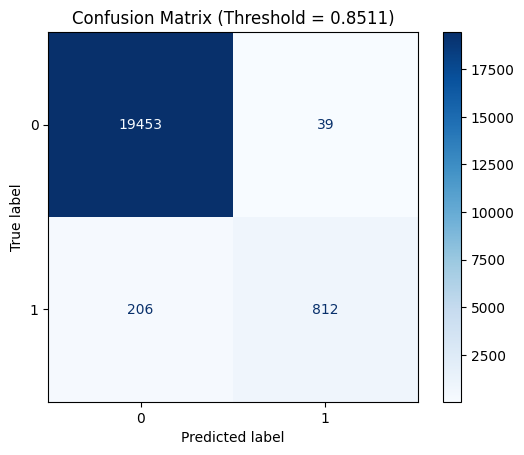

 Accuracy: 0.9880546075085325

 Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     19492
           1       0.95      0.80      0.87      1018

    accuracy                           0.99     20510
   macro avg       0.97      0.90      0.93     20510
weighted avg       0.99      0.99      0.99     20510



In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report,precision_recall_curve
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib # Import joblib

# Bước 1: Đọc dữ liệu
df = pd.read_csv("data_train.csv")  # có thể đổi sang modin.pandas nếu muốn xử lý nhanh hơn

# Bước 2: Tiền xử lý
drop_cols = ['local_timestamp', 'time', 'date', 'IP','device_id','merchant_id']  # loại bỏ các cột không cần thiết
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# Mã hóa one-hot các cột phân loại
categorical_cols = [
    'currency', 'payment_channel', 'card_present', 'card_entry_mode',
    'auth_result', 'tokenised', 'recurring_flag', 'cross_border',
    'auth_characteristics', 'message_type','merchant_country','pin_verif_method','term_location'
]
categorical_cols = [col for col in categorical_cols if col in df.columns]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Chuyển định dạng số có dấu phẩy sang dấu chấm
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = df[col].str.replace(',', '.').astype(float)
        except:
            pass

# Tách dữ liệu
X = df.drop('fraud', axis=1)
y = df['fraud']

# Chuẩn hóa
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Tính scale_pos_weight = số mẫu lớp 0 / số mẫu lớp 1
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# Huấn luyện mô hình XGBoost
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, 'xgboost_model.pkl')
print("Model saved as xgboost_model.pkl")

# Dự đoán & đánh giá
y_pred = model.predict(X_test)

#print(" Accuracy:", accuracy_score(y_test, y_pred))
#print("\n Classification Report:\n", classification_report(y_test, y_pred))
# 1️ Dự đoán xác suất cho lớp 1
y_proba = model.predict_proba(X_test)[:, 1]

# 2️ Tính precision, recall và thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# 3️ Tính F1-score tương ứng với từng threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)  # tránh chia cho 0

# 4️ Tìm threshold tối ưu cho F1-score cao nhất
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f" Best threshold: {best_threshold:.4f} with F1-score: {best_f1:.4f}")

# 5️ Dự đoán với threshold tối ưu
y_pred_optimal = (y_proba >= best_threshold).astype(int)

# 6️ Đánh giá mô hình với ngưỡng tối ưu
from sklearn.metrics import accuracy_score, classification_report

cm = confusion_matrix(y_test, y_pred_optimal)
labels = model.classes_  # [0, 1]

# Hiển thị confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix (Threshold = {best_threshold:.4f})")
plt.grid(False)
plt.show()
print(" Accuracy:", accuracy_score(y_test, y_pred_optimal))
print("\n Classification Report:\n", classification_report(y_test, y_pred_optimal))